# Results

As mentioned, the models were evaluated using three criteria: the accuracy of the outputted steering angles, the stability of the outputs, and it's real time performance. The testing of the steering angle accuracy was determined by the model's immediate evaluation accuracy using Keras' `Model.evaluate()` to determine it's prediction MSE, and `Model.predict()` to get a single frame sample of the output angle. The stability of the outputted steering angles was determined qualitative observation in the PiCar Simulator, observing the predictions on straights or steady turns on a track. Finally, real time performance was determined through integration tests with the PiCar in the labs, with the FPS counter in the video stream window from the `carRunner.py` script. The size of the model, both in terms of `.h5` file size and number of parameters, were used as a rough benchmark for real time performance in the absence of testing. Since our access to the PiCar in the labs was limited, only the last two models were tested for real time performance.

## Prediction Accuracy

2025-04-09 19:16:31.231813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-09 19:16:31.252105: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-09 19:16:31.256880: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-09 19:16:31.324474: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1744251391.620705    12

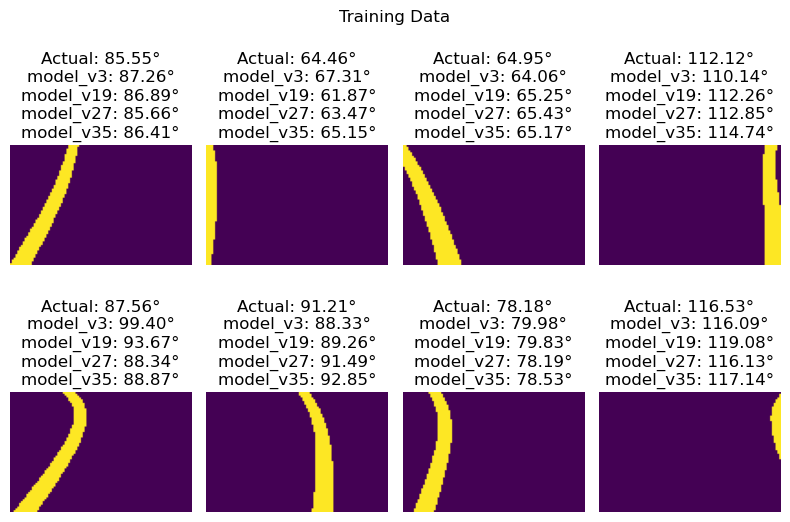

In [2]:
from pathlib import Path

import keras
import numpy as np

# Helper functions for loading and processing images
from my_models import (
    dataset_file_get_steering_angle as get_angle,
    display_results,
    process_image
)

evaluation_size = 1024
np_rng = np.random.default_rng(42)

# load test images
test_images = list(Path.cwd().glob('**/test/*.png'))
np_rng.shuffle(test_images)
test_images = test_images[:evaluation_size]

test_labels = np.array([get_angle(img) for img in test_images])
test_data = np.array([process_image(img) for img in test_images])
test_data = np.expand_dims(test_data, axis=-1)

results = []
eval = []
model_names = ['model_v3', 'model_v19', 'model_v27', 'model_v35']

for name in model_names:
    model = keras.models.load_model(
        name + '.h5',
        custom_objects={'mse': keras.losses.MeanSquaredError}
    )
    results.append(model.predict(test_data, verbose=0))
    eval.append(model.evaluate(test_data, test_labels,verbose=0))
results = np.array(results)

display_results(test_data, test_labels, results, model_names)

In [5]:
from tabulate import tabulate

table = [[name, mse] for name, mse in zip(model_names, eval)]
print(tabulate(
    table,
    headers=['Model', 'MSE'],
    tablefmt='fancy_grid',
    stralign='center'
))

╒═══════════╤═════════╕
│   Model   │     MSE │
╞═══════════╪═════════╡
│ model_v3  │ 14.4784 │
├───────────┼─────────┤
│ model_v19 │ 20.0642 │
├───────────┼─────────┤
│ model_v27 │  6.567  │
├───────────┼─────────┤
│ model_v35 │ 10.537  │
╘═══════════╧═════════╛


## Steering Stability 

| Model | Size | Jitter |
| --- | --- | --- |
| v3 | 34MB | ±15° |
| v19 | 5.3MB | ±8° |
| v27 | 925KB | ±3° |
| v35 | 230KB | ±6° |

Model V3:
```
Epoch 21/25
800/800 ━━━━━━━━━━━━ 6s 8ms/step - loss: 9.1319 - val_loss: 26.2681
Epoch 22/25
800/800 ━━━━━━━━━━━━ 6s 8ms/step - loss: 9.0614 - val_loss: 23.0115
Epoch 23/25
800/800 ━━━━━━━━━━━━ 6s 8ms/step - loss: 8.1851 - val_loss: 19.1624
Epoch 24/25
800/800 ━━━━━━━━━━━━ 6s 8ms/step - loss: 7.7027 - val_loss: 20.7945
Epoch 25/25
800/800 ━━━━━━━━━━━━ 6s 8ms/step - loss: 8.0659 - val_loss: 18.5401
```

Model V19
```
Epoch 146/150
800/800 ━━━━━━━━━━━━ 2s 3ms/step - loss: 9.7535 - val_loss: 22.2732
Epoch 147/150
800/800 ━━━━━━━━━━━━ 2s 3ms/step - loss: 9.0911 - val_loss: 23.9203
Epoch 148/150
800/800 ━━━━━━━━━━━━ 2s 3ms/step - loss: 9.8172 - val_loss: 22.5343
Epoch 149/150
800/800 ━━━━━━━━━━━━ 2s 3ms/step - loss: 9.2620 - val_loss: 18.2970
Epoch 150/150
800/800 ━━━━━━━━━━━━ 2s 3ms/step - loss: 9.9574 - val_loss: 22.8255
```

Model V27
```
Epoch 160: Loss = 8.1457, Val Loss = 8.9514
Epoch 170: Loss = 8.2891, Val Loss = 8.7408
Epoch 180: Loss = 8.2174, Val Loss = 8.9240
Epoch 190: Loss = 8.1440, Val Loss = 8.5655
Epoch 200: Loss = 8.2459, Val Loss = 8.4164
```

Model V35
```
Epoch 60: Loss = 13.9307, Val Loss = 22.8190
Epoch 70: Loss = 13.5184, Val Loss = 29.6004
Epoch 80: Loss = 13.3570, Val Loss = 23.0545
Epoch 90: Loss = 14.0007, Val Loss = 15.1174
Epoch 100: Loss = 13.9785, Val Loss = 11.5439
```

In [10]:
from decimal import Decimal

for model in Path.cwd().glob('**/*.h5'):
    status = model.stat()
    print(model.name, status.st_size)

model_v35.h5 234688
model_v19.h5 5477984
model_v3.h5 34880432
model_v27.h5 946392
